In [1]:
import numpy as np
import cv2
from skimage.io import imread
from skimage.transform import resize

import matplotlib.pyplot as plt
from glob import glob

%matplotlib inline
%load_ext autoreload
%autoreload 2


In [2]:
def visualize(images, samples_per_row=4, title=False):
    sample_rows = len(images) // samples_per_row
    fig, m_axs = plt.subplots(sample_rows, samples_per_row, figsize = (20, 6*sample_rows))
    [c_ax.axis('off') for c_ax in m_axs.flatten()]
    for ax, image in zip(m_axs.flatten(), images):
        img = imread(image)
        ax.imshow(img, cmap='gray')

def visualize_single(image, gray=True):
    if type(image) == np.str_:
        image = imread(image)
        
    plt.figure(figsize=(20, 10))
    if gray:
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(image)

def smooth(x, window_len=11, window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    
    return y

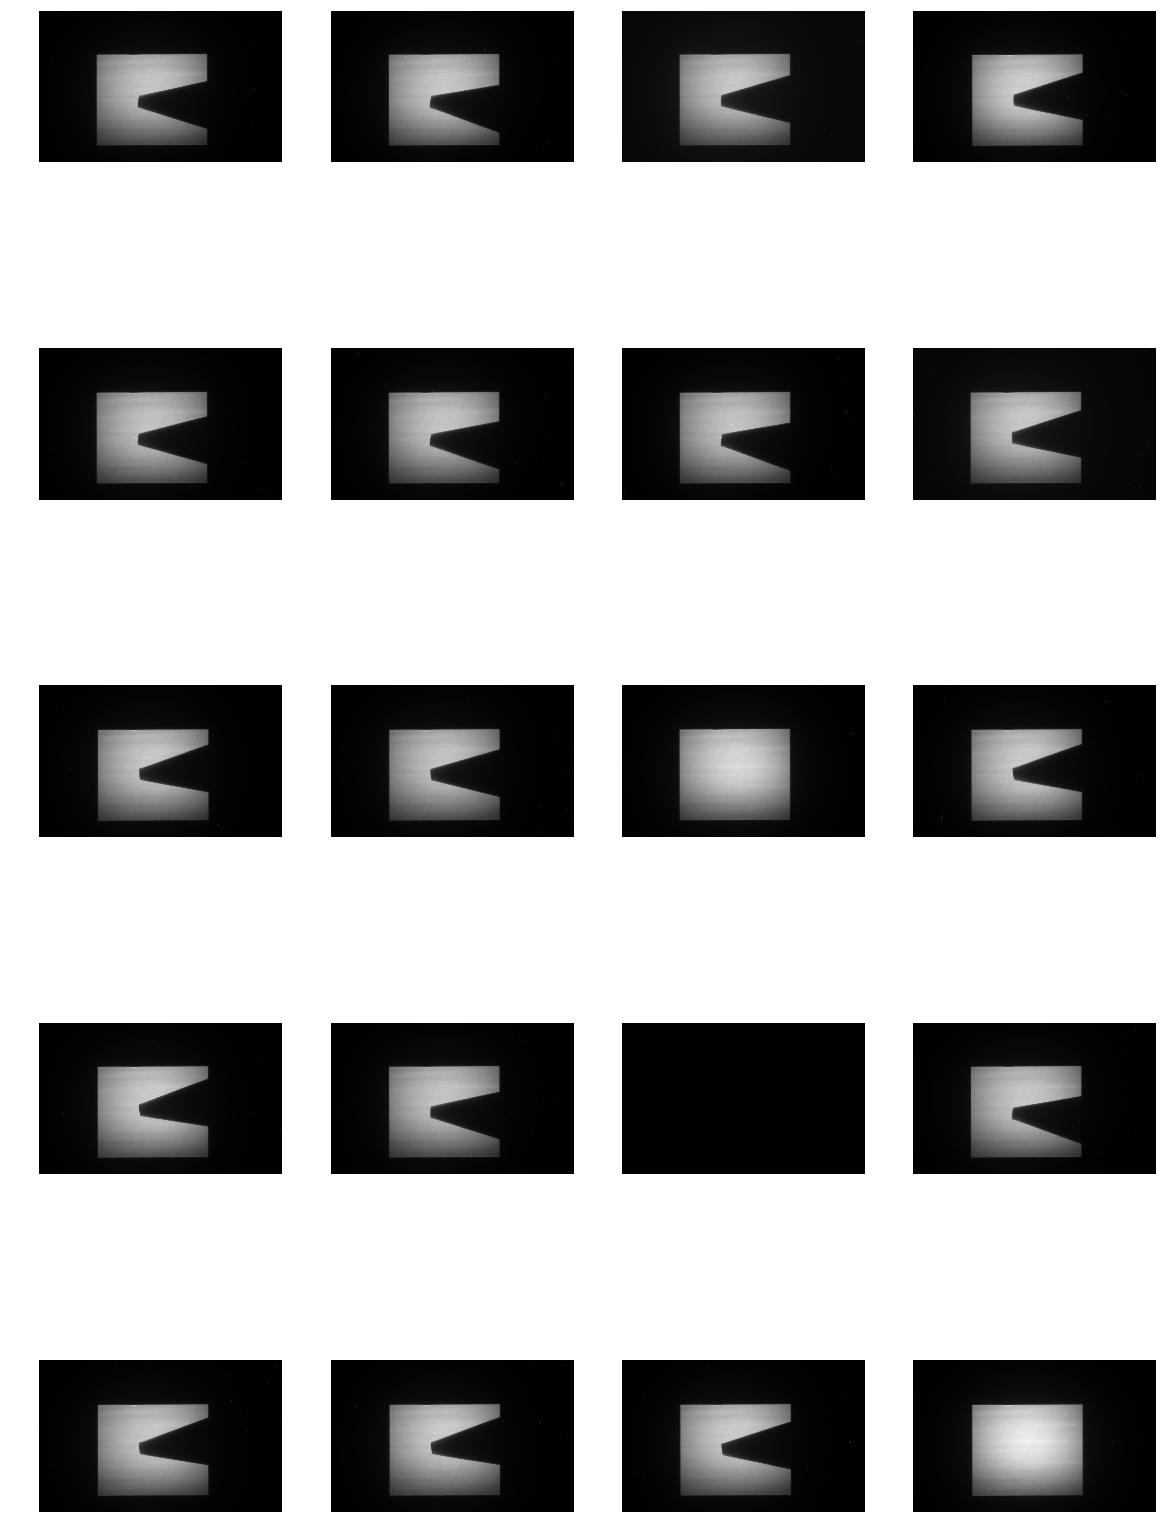

In [3]:
images = glob('./data/pin_tomo/*.tif')
visualize(images)

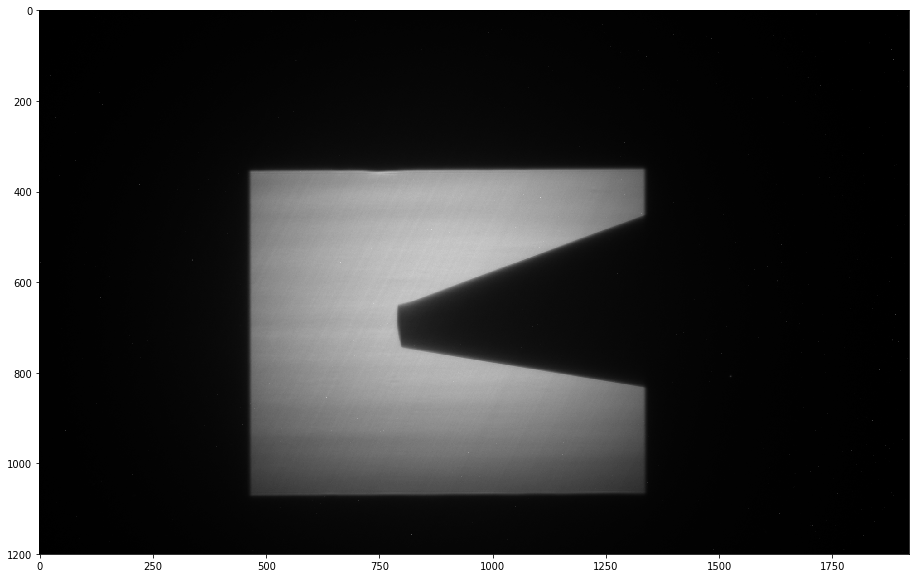

In [4]:
image = np.random.choice(images)
visualize_single(image)

/Users/faisal/anaconda3/envs/py36/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/faisal/anaconda3/envs/py36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


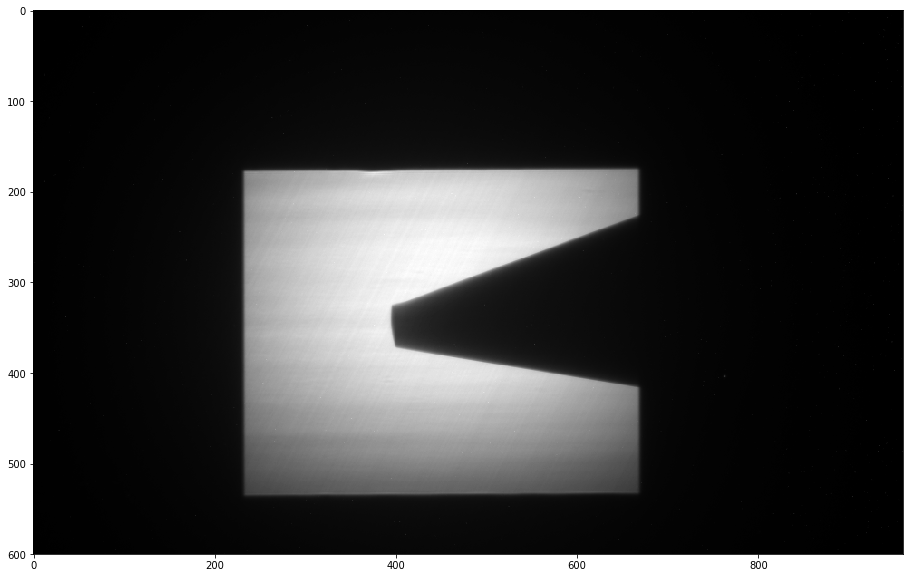

In [5]:
img = imread(image)
img2 = np.copy(img)
ratio = img2.shape[1] / img2.shape[0]
h = 600
img2 = resize(img, (h, h*ratio))
visualize_single(img2)

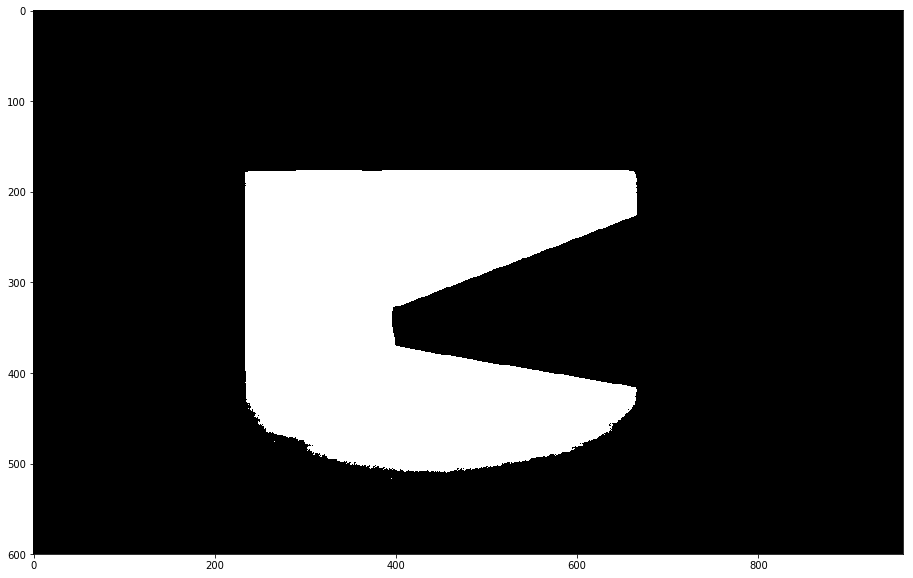

In [6]:
binary = np.zeros_like(img2)
binary[img2 > 0.4] = 1
visualize_single(binary)

/Users/faisal/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in int_scalars
  from ipykernel import kernelapp as app


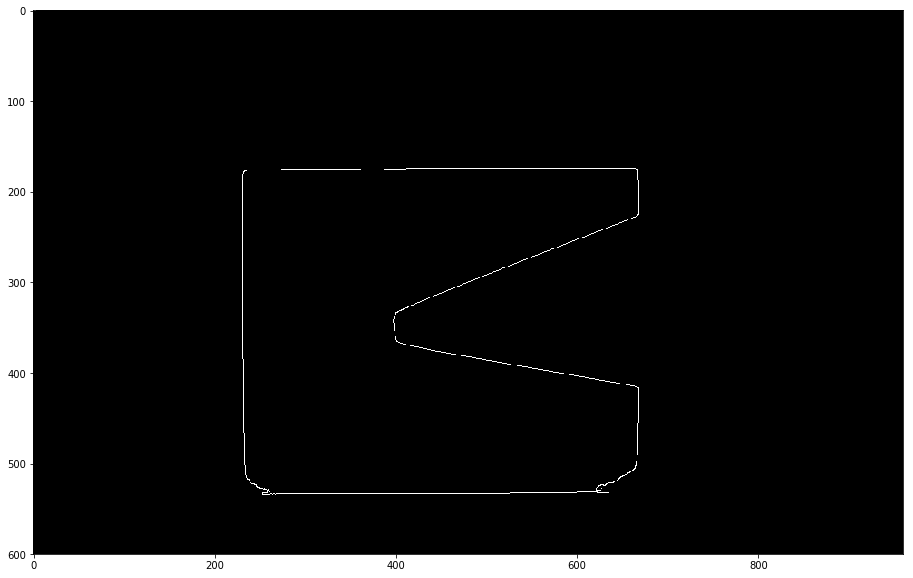

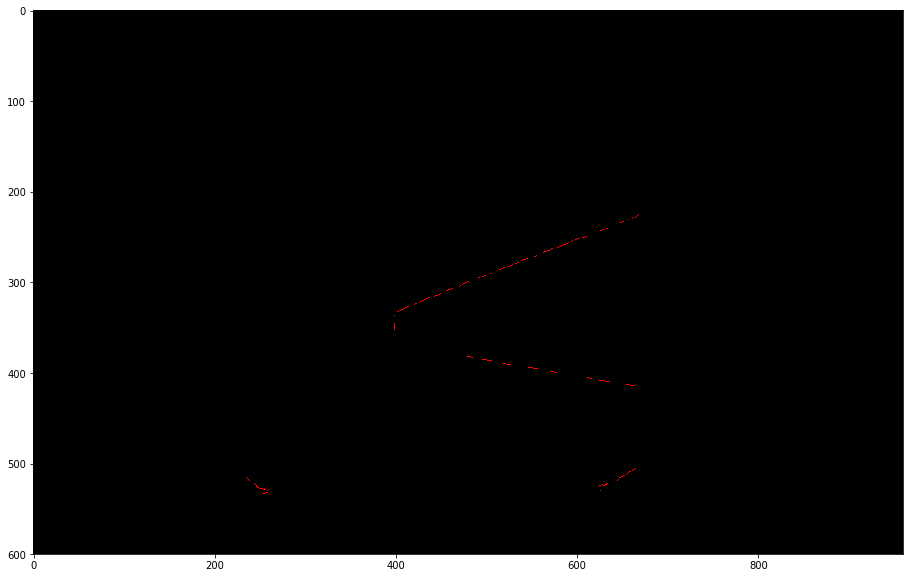

In [7]:
binary = np.zeros_like(img2)
binary[img2 > 0.25] = 1
binary = np.uint8(binary)

edges = cv2.Canny(binary, 0.5, 1, apertureSize = 7)

visualize_single(edges)

lines = cv2.HoughLinesP(edges, 1, np.pi/180, 5, 5, 1);
# lines = cv2.HoughLines(edges, 1, np.pi/2, 200)
lines = lines.squeeze()

output = np.dstack((binary, binary, binary))
for x0, y0, x1, y1 in lines:
    slope = (y1 - y0) / (x1 - x0)
    
    if abs(slope) != 0 and abs(slope) != float('inf'):
        cv2.line(output, (x0, y0), (x1, y1), (255,0,0), 1)

visualize_single(output, False)



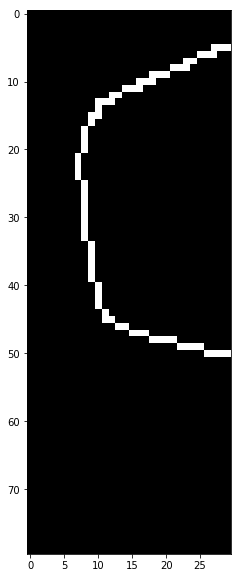

In [89]:
yslice, xslice = slice(320,400), slice(390, 420)
# output = edges[:, :, 0]
patch = edges[yslice, xslice]
visualize_single(patch)

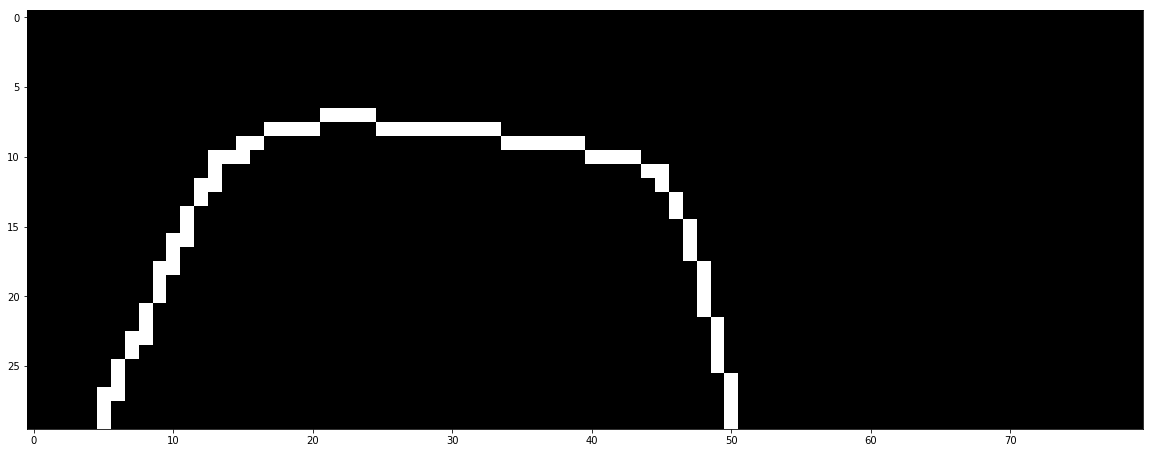

In [90]:
visualize_single(np.transpose(patch))

In [91]:
x, y = np.nonzero(patch)

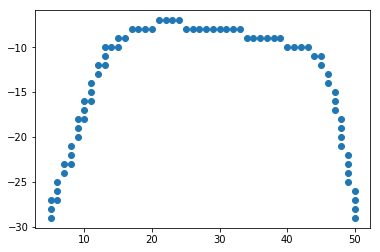

In [92]:
plt.scatter(x, -y)

In [93]:
x

array([ 5,  5,  5,  6,  6,  6,  7,  7,  8,  8,  8,  9,  9,  9, 10, 10, 10,
       11, 11, 11, 12, 12, 13, 13, 13, 14, 15, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
       39, 40, 41, 42, 43, 44, 45, 45, 46, 46, 47, 47, 47, 48, 48, 48, 48,
       49, 49, 49, 49, 50, 50, 50, 50])

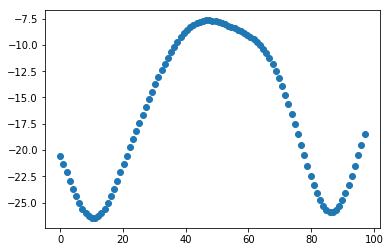

In [94]:
ysmooth =  smooth(-y,22)
xindices = np.linspace(0, len(ysmooth), len(ysmooth))
plt.scatter(xindices, ysmooth)

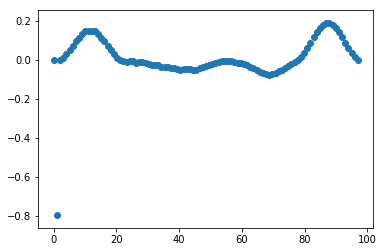

In [95]:
y_df1 = np.insert(np.diff(ysmooth), 0, 0)
y_df2 = np.insert(np.diff(y_df1), 0, 0) 

plt.scatter(np.linspace(0, len(y_df1), len(y_df2)), y_df2)

In [96]:
x_dec = np.where(y_df2 == min(y_df2))[0][0]
x_inc = np.where(y_df2 == max(y_df2))[0][0]

print(x_dec, x_inc)

1 86


In [97]:
max_pt = np.argmax(ysmooth)
print(max_pt)

46


In [98]:
data = ysmooth[max(0, max_pt-30):max_pt+30]
print(data)

[-24.38136359 -23.67395334 -22.9151217  -22.12575142 -21.32732315
 -20.52942892 -19.73949769 -18.96001976 -18.18409425 -17.41508254
 -16.65996287 -15.91390118 -15.17760532 -14.45726217 -13.7576411
 -13.08378585 -12.43421957 -11.81376955 -11.23102274 -10.68486921
 -10.17729435  -9.71320236  -9.29151825  -8.9158612   -8.59210745
  -8.31729023  -8.09044128  -7.91267691  -7.78498319  -7.70812836
  -7.67413226  -7.67543768  -7.70981304  -7.77208838  -7.85461466
  -7.95217464  -8.06033086  -8.17581991  -8.29684239  -8.42322283
  -8.55642526  -8.69942312  -8.85643507  -9.03043456  -9.22500119
  -9.44611826  -9.70164108 -10.00059905 -10.3523933  -10.76596142
 -11.24898324 -11.80719852 -12.44178132 -13.14923569 -13.92382187
 -14.75806634 -15.6434258  -16.57104634 -17.53043456 -18.51038992]


In [99]:
d = np.sign(np.diff(data))
d 

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1.])

In [100]:
np.where(np.convolve(d, [-1, 1]) == 2)

(array([30]),)

In [101]:
len(np.where(np.convolve(d, [-1, 0, -1]) == 2)[0])

27

In [102]:
sum(d[:max_pt])

14.0

In [103]:
sum(d[max_pt:])

-13.0

In [104]:
xslice


slice(390, 420, None)

In [105]:
yslice

slice(320, 400, None)

In [106]:
xslice.start + max_pt

436

In [115]:
yptr = y[max_pt]


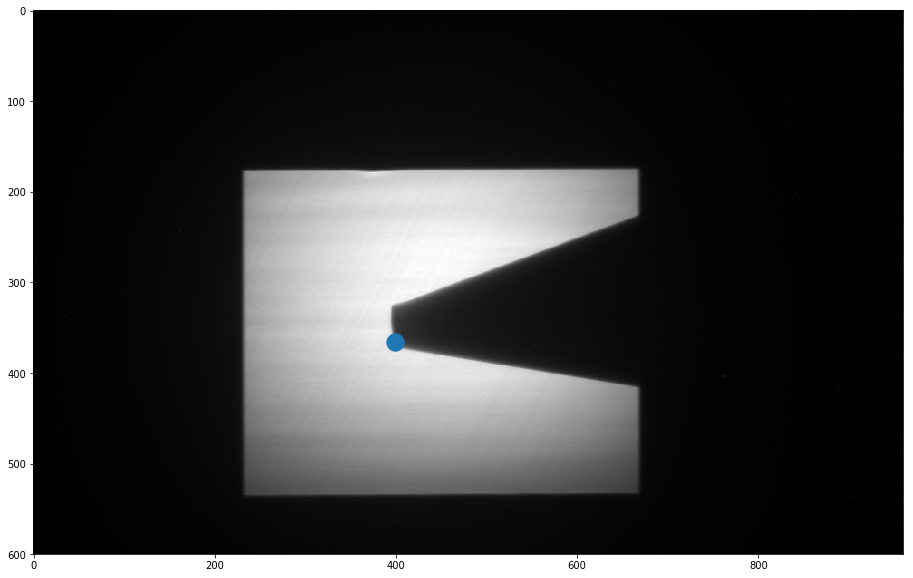

In [116]:
plt.figure(figsize=(20, 10))
plt.imshow(img2, cmap='gray')
plt.scatter(xslice.start+yptr, yslice.start+max_pt, s=300)